### Introduction

This is the code for the proposed VMA framework's model training, prediction fusion, confidence-based pseudo-labeled data selection and weight-reusing based model transfer.
Some disclamation of this demo notebook:
- This notebook assumes you have cleaned the data, extracted the feature and have a transfer path. We use hand-crafted feature in our original paper. If you are a fan of deep features, please refer to `demo_future_direction.ipynb`.
- This notebook has some repetitive code blocks, e.g., data preprocessing, model training. I can certainly wrap them into a function, but I think that will be hard to track. Therefore I keep this style.
- For the variable naming. We have mainly two modalities, IMU and Vibration sensor. Also, we have two areas (if you read the paper, you will know). Therefore, you may find similar variables with different tails, like '_v', '_w'. It means this is the variable for specific modality and/or area.

In [1]:
'''
Coded by Kevin Hu.
Contact: www.kevin-hu.com
'''
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.io import loadmat
from scipy.io import savemat
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from utils import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Prepare Data

In [2]:
# order of transfer
# person/subject
sub = [4,3,3]
# location
loc = [2,2,1]

In [3]:
batch_size = 256
num_epoch = 300
l_r = 0.001 # learning rate
verbose = 0 # verbose for model train information, if verbose, loss of epochs will show
save_inter = 1 # whether save the intermediate result or not
save_final = 1 # whether save the final result or not
eta = 0.8 # the threshold for confidence-based pseudo-label selection

In [4]:
# loss function and optimizer for each modality
loss_i = keras.losses.CategoricalCrossentropy(from_logits=True)
loss_v = keras.losses.CategoricalCrossentropy(from_logits=True)
opt_i= keras.optimizers.Adam(learning_rate=l_r)
opt_v= keras.optimizers.Adam(learning_rate=l_r)
# performance metric for first-step analysis
acc_metric = keras.metrics.CategoricalAccuracy()

In [5]:
# read in the data
imu_path = '../data_extracted/imu/'
vib_path = '../data_extracted/vib/'
df1 = pd.read_csv(imu_path + 'p' + str(sub[0]) + 'l' + str(loc[0]) + '_extr.csv')
df2 = pd.read_csv(imu_path + 'p' + str(sub[1]) + 'l' + str(loc[1]) + '_extr.csv')
df3 = pd.read_csv(vib_path + 'p' + str(sub[0]) + 'l' + str(loc[0]) + '_vib_extr.csv')
df4 = pd.read_csv(vib_path + 'p' + str(sub[1]) + 'l' + str(loc[1]) + '_vib_extr.csv')

# df 5 and df6 are the data for the final transfer
df5 = pd.read_csv(imu_path + 'p' + str(sub[2]) + 'l' + str(loc[2]) + '_extr.csv')
df6 = pd.read_csv(vib_path + 'p' + str(sub[2]) + 'l' + str(loc[2]) + '_vib_extr.csv') 

# name coded for further convenience 
d1_i = df1
d2_i = df2
d3_i = df5
d1_v = df3
d2_v = df4
d3_v = df6


In [6]:
##  Studing Area (w for working)
d1_i_w = d1_i[d1_i['co']==1]
d2_i_w = d2_i[d2_i['co']==1]
d3_i_w = d3_i[d3_i['co']==1]
d1_v_w = d1_v[d1_v['co']==1]
d2_v_w = d2_v[d2_v['co']==1]
d3_v_w = d3_v[d3_v['co']==1]

##  Living Area (k for kitchen)
d1_i_k = d1_i[d1_i['co']!=1]
d2_i_k = d2_i[d2_i['co']!=1]
d3_i_k = d3_i[d3_i['co']!=1]
d1_v_k = d1_v[d1_v['co']!=1]
d2_v_k = d2_v[d2_v['co']!=1]
d3_v_k = d3_v[d3_v['co']!=1]

In [7]:
# form the data
# train: source domain 
# inter: intermdeiate domain 
# tar: target domain
train_i_w = d1_i_w
inter_i_w = d2_i_w
tar_i_w = d3_i_w
train_v_w = d1_v_w
inter_v_w = d2_v_w
tar_v_w = d3_v_w

train_i_k = d1_i_k
inter_i_k = d2_i_k
tar_i_k = d3_i_k

train_v_k = d1_v_k
inter_v_k = d2_v_k
tar_v_k = d3_v_k

In [8]:
# IMU of activities in Studying Area
X_train_i_w = train_i_w.iloc[:,2:]
y_train_i_w = train_i_w.iloc[:,0]-1 # to have zero-indexing
X_inter_i_w = inter_i_w.iloc[:,2:]
y_inter_i_w = inter_i_w.iloc[:,0]-1
X_tar_i_w = tar_i_w.iloc[:,2:]
y_tar_i_w = tar_i_w.iloc[:,0]-1

# IMU of activities in Living Area
X_train_i_k = train_i_k.iloc[:,2:]
y_train_i_k = train_i_k.iloc[:,0]-1
X_inter_i_k = inter_i_k.iloc[:,2:]
y_inter_i_k = inter_i_k.iloc[:,0]-1
X_tar_i_k = tar_i_k.iloc[:,2:]
y_tar_i_k = tar_i_k.iloc[:,0]-1

# Vibration of activities in Studying Area
X_train_v_w = train_v_w.iloc[:,982:] # use studying area vibration sensors 
y_train_v_w = train_v_w.iloc[:,0]-1
X_inter_v_w = inter_v_w.iloc[:,982:]
y_inter_v_w = inter_v_w.iloc[:,0]-1
X_tar_v_w = tar_v_w.iloc[:,982:]
y_tar_v_w = tar_v_w.iloc[:,0]-1

# Vibration of activities in Living Area
X_train_v_k = train_v_k.iloc[:,2:982] # use living area vibration sensors
y_train_v_k = train_v_k.iloc[:,0]-1
X_inter_v_k = inter_v_k.iloc[:,2:982]
y_inter_v_k = inter_v_k.iloc[:,0]-1
X_tar_v_k = tar_v_k.iloc[:,2:982]
y_tar_v_k = tar_v_k.iloc[:,0]-1

In [9]:
# standardize feature space
scaler_ik = StandardScaler()
X_train_i_k = scaler_ik.fit_transform(X_train_i_k)
X_inter_i_k = scaler_ik.fit_transform(X_inter_i_k)
X_tar_i_k = scaler_ik.fit_transform(X_tar_i_k)

scaler_iw = StandardScaler()
X_train_i_w = scaler_iw.fit_transform(X_train_i_w)
X_inter_i_w = scaler_iw.fit_transform(X_inter_i_w)
X_tar_i_w = scaler_iw.fit_transform(X_tar_i_w)

scaler_vk = StandardScaler()
X_train_v_k = scaler_vk.fit_transform(X_train_v_k)
X_inter_v_k = scaler_vk.fit_transform(X_inter_v_k)
X_tar_v_k = scaler_vk.fit_transform(X_tar_v_k)

scaler_vw = StandardScaler()
X_train_v_w = scaler_vw.fit_transform(X_train_v_w)
X_inter_v_w = scaler_vw.fit_transform(X_inter_v_w)
X_tar_v_w = scaler_vw.fit_transform(X_tar_v_w)

In [10]:
# prepare the data in the format of neural network for the first run of transfer (source to the intermediate)
encoder = OneHotEncoder()
# studying area
y_train_i_w_keras = encoder.fit_transform(np.array(y_train_i_w).reshape(-1, 1))
y_inter_i_w_keras = encoder.fit_transform(np.array(y_inter_i_w).reshape(-1, 1))
y_train_i_w_keras = y_train_i_w_keras.todense()
y_inter_i_w_keras = y_inter_i_w_keras.todense()

y_train_v_w_keras = encoder.fit_transform(np.array(y_train_v_w).reshape(-1, 1))
y_inter_v_w_keras = encoder.fit_transform(np.array(y_inter_v_w).reshape(-1, 1))
y_train_v_w_keras = y_train_v_w_keras.todense()
y_inter_v_w_keras = y_inter_v_w_keras.todense()

y_tar_i_w_keras = encoder.fit_transform(np.array(y_tar_i_w).reshape(-1, 1))
y_tar_i_w_keras = y_tar_i_w_keras.todense()
y_tar_v_w_keras = encoder.fit_transform(np.array(y_tar_v_w).reshape(-1, 1))
y_tar_v_w_keras = y_tar_v_w_keras.todense()

# split some validation data for monitoring model training
X_train_i_w_keras, X_val_i_w_keras, y_train_i_w_keras, y_val_i_w_keras = train_test_split(X_train_i_w, y_train_i_w_keras, test_size=0.2)
X_train_v_w_keras, X_val_v_w_keras, y_train_v_w_keras, y_val_v_w_keras = train_test_split(X_train_v_w, y_train_v_w_keras, test_size=0.2)

# living area
y_train_i_k_keras = encoder.fit_transform(np.array(y_train_i_k).reshape(-1, 1))
y_inter_i_k_keras = encoder.fit_transform(np.array(y_inter_i_k).reshape(-1, 1))
y_train_i_k_keras = y_train_i_k_keras.todense()
y_inter_i_k_keras = y_inter_i_k_keras.todense()

y_train_v_k_keras = encoder.fit_transform(np.array(y_train_v_k).reshape(-1, 1))
y_inter_v_k_keras = encoder.fit_transform(np.array(y_inter_v_k).reshape(-1, 1))
y_train_v_k_keras = y_train_v_k_keras.todense()
y_inter_v_k_keras = y_inter_v_k_keras.todense()

y_tar_i_k_keras = encoder.fit_transform(np.array(y_tar_i_k).reshape(-1, 1))
y_tar_i_k_keras = y_tar_i_k_keras.todense()
y_tar_v_k_keras = encoder.fit_transform(np.array(y_tar_v_k).reshape(-1, 1))
y_tar_v_k_keras = y_tar_v_k_keras.todense()

X_train_i_k_keras, X_val_i_k_keras, y_train_i_k_keras, y_val_i_k_keras = train_test_split(X_train_i_k, y_train_i_k_keras, test_size=0.2)
X_train_v_k_keras, X_val_v_k_keras, y_train_v_k_keras, y_val_v_k_keras = train_test_split(X_train_v_k, y_train_v_k_keras, test_size=0.2)


In [11]:
# format the data into a tf dataset for alternative training
# studying area
train_i_w_dataset = tf.data.Dataset.from_tensor_slices((X_train_i_w_keras, y_train_i_w_keras))
train_i_w_dataset = train_i_w_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_v_w_dataset = tf.data.Dataset.from_tensor_slices((X_train_v_w_keras, y_train_v_w_keras))
train_v_w_dataset = train_v_w_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_i_w_dataset = tf.data.Dataset.from_tensor_slices((X_val_i_w_keras, y_val_i_w_keras))
val_i_w_dataset = val_i_w_dataset.batch(batch_size)
val_v_w_dataset = tf.data.Dataset.from_tensor_slices((X_val_v_w_keras, y_val_v_w_keras))
val_v_w_dataset = val_v_w_dataset.batch(batch_size)
inter_i_w_dataset = tf.data.Dataset.from_tensor_slices((X_inter_i_w, y_inter_i_w_keras))
inter_i_w_dataset = inter_i_w_dataset.batch(batch_size)
inter_v_w_dataset = tf.data.Dataset.from_tensor_slices((X_inter_v_w, y_inter_v_w_keras))
inter_v_w_dataset = inter_v_w_dataset.batch(batch_size)

# living area
train_i_k_dataset = tf.data.Dataset.from_tensor_slices((X_train_i_k_keras, y_train_i_k_keras))
train_i_k_dataset = train_i_k_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_v_k_dataset = tf.data.Dataset.from_tensor_slices((X_train_v_k_keras, y_train_v_k_keras))
train_v_k_dataset = train_v_k_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_i_k_dataset = tf.data.Dataset.from_tensor_slices((X_val_i_k_keras, y_val_i_k_keras))
val_i_k_dataset = val_i_k_dataset.batch(batch_size)
val_v_k_dataset = tf.data.Dataset.from_tensor_slices((X_val_v_k_keras, y_val_v_k_keras))
val_v_k_dataset = val_v_k_dataset.batch(batch_size)
inter_i_k_dataset = tf.data.Dataset.from_tensor_slices((X_inter_i_k, y_inter_i_k_keras))
inter_i_k_dataset = inter_i_k_dataset.batch(batch_size)
inter_v_k_dataset = tf.data.Dataset.from_tensor_slices((X_inter_v_k, y_inter_v_k_keras))
inter_v_k_dataset = inter_v_k_dataset.batch(batch_size)

### Predicting the Intermediate Domain
Network for studying area

In [12]:
# shared layers
share_input = layers.Input(shape=(128,))
s_1 = layers.Dense(64, activation="elu", name = 'share_1')(share_input)
s_1 = layers.Dropout(0.5)(s_1)
s_2 = layers.Dense(32, activation="elu", name = 'share_2')(s_1)
s_2 = layers.Dropout(0.5)(s_2)
shared_layers_w = keras.Model(inputs=share_input, outputs=s_2, name="middle_model")

# modality-specific input layer
input_i = layers.Input(shape=(216,))
input_v = layers.Input(shape=(980,))
x_i_1 = layers.Dense(128, activation="elu", name = 'X_i_1')(input_i)
x_i_d = layers.Dropout(0.5, name = 'i_dropout')(x_i_1)
x_v_1 = layers.Dense(128, activation="elu", name = 'X_v_1')(input_v)
x_v_d = layers.Dropout(0.5, name = 'v_dropout')(x_v_1)

# combined together
x_imu = shared_layers_w(x_i_d)
x_vib = shared_layers_w(x_v_d )
output_i = layers.Dense(4)(x_imu)
output_v = layers.Dense(3)(x_vib)
model_iw = keras.Model(inputs=input_i, outputs=output_i, name="imu_model")
model_vw = keras.Model(inputs=input_v, outputs=output_v, name="vib_model")

# saving results for further plotting
keras.backend.clear_session()
train_loss_i = list()
val_loss_i = list()
train_loss_v = list()
val_loss_v = list()

In [13]:
flag = 1 # for the alternative training
for epoch in range(num_epoch):
    if verbose:
        print("\nStart of epoch %d" % (epoch,))
    if flag >= 0:
        # Iterate over the batches of the dataset.
        for step, (x_batch_train_i, y_batch_train_i) in enumerate(train_i_w_dataset):
            with tf.GradientTape() as tape:
                logits_i = model_iw(x_batch_train_i, training=True)  # Logits for this minibatch
                loss_value_i = loss_i(y_batch_train_i, logits_i)
            grads_i = tape.gradient(loss_value_i, model_iw.trainable_weights)
            opt_i.apply_gradients(zip(grads_i, model_iw.trainable_weights))
        if verbose:
            print("Training loss of model_iw at epoch %d: %.4f" % (epoch + 1, float(loss_value_i)))

        for x_batch_val_i, y_batch_val_i in val_i_w_dataset:
            val_logits_i = model_iw(x_batch_val_i, training=False)
            val_loss_value_i = loss_i(y_batch_val_i, val_logits_i)
        if verbose:
            print("Val loss of model_iw at epoch %d: %.4f"% (epoch + 1, float(val_loss_value_i)))
        train_loss_i.append(float(loss_value_i))
        val_loss_i.append(float(val_loss_value_i))
        flag *= -1 # next epoch is trained with another modality

    else:
        for step, (x_batch_train_v, y_batch_train_v) in enumerate(train_v_w_dataset):
            with tf.GradientTape() as tape:
                logits_v = model_vw(x_batch_train_v, training=True)  # Logits for this minibatch
                loss_value_v = loss_v(y_batch_train_v, logits_v)
            grads_v = tape.gradient(loss_value_v, model_vw.trainable_weights)
            opt_v.apply_gradients(zip(grads_v, model_vw.trainable_weights))
        if verbose:
            print("Training loss of model_vw at epoch %d: %.4f"% (epoch + 1, float(loss_value_v)))

        for x_batch_val_v, y_batch_val_v in val_v_w_dataset:
            val_logits_v = model_vw(x_batch_val_v, training=False)
            val_loss_value_v = loss_v(y_batch_val_v, val_logits_v)
        if verbose:
            print("Val loss of model_vw at epoch %d: %.4f" % (epoch + 1, float(val_loss_value_v)))
        train_loss_v.append(float(loss_value_v))
        val_loss_v.append(float(val_loss_value_v))
        flag *= -1

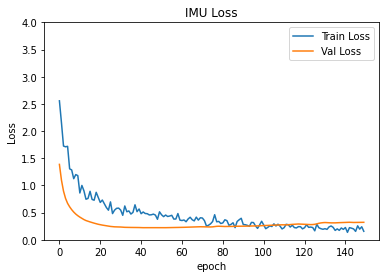

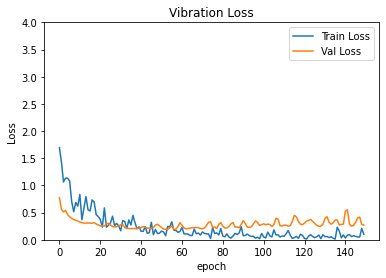

In [14]:
plt.plot(train_loss_i)
plt.plot(val_loss_i)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("IMU Loss")
plt.legend(['Train Loss', 'Val Loss'])
plt.ylim([0, 4])
plt.show()

plt.plot(train_loss_v)
plt.plot(val_loss_v)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Vibration Loss")
plt.legend(['Train Loss', 'Val Loss'])
plt.ylim([0, 4])
plt.show()

In [15]:
# initialize the confidence matrix
inter_imu_conf_w = np.zeros((y_inter_i_w.shape[0],4))
inter_vib_conf_w = np.zeros((y_inter_v_w.shape[0],3))
tar_imu_conf_w = np.zeros((y_tar_i_w.shape[0],4))
tar_vib_conf_w = np.zeros((y_tar_v_w.shape[0],3))
# establish tensorflow.data.dataset for prediction evaluation and prediction confidence matrix
inter_i_w_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_inter_i_w, y_inter_i_w_keras))
inter_i_w_dataset_for_eval = inter_i_w_dataset_for_eval.batch(1) #set batch size to 1 for to generate the confidence matrix
inter_v_w_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_inter_v_w, y_inter_v_w_keras))
inter_v_w_dataset_for_eval = inter_v_w_dataset_for_eval.batch(1)
tar_i_w_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_tar_i_w, y_tar_i_w_keras))
tar_i_w_dataset_for_eval = tar_i_w_dataset_for_eval.batch(1)
tar_v_w_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_tar_v_w, y_tar_v_w_keras))
tar_v_w_dataset_for_eval = tar_v_w_dataset_for_eval.batch(1)

In [16]:
inter_acc_v_w, inter_vib_conf_w = model_evaluate(model_vw, acc_metric, inter_v_w_dataset_for_eval, inter_vib_conf_w)
inter_acc_i_w, inter_imu_conf_w = model_evaluate(model_iw, acc_metric, inter_i_w_dataset_for_eval, inter_imu_conf_w)
tar_acc_v_w, tar_vib_conf_w = model_evaluate(model_vw, acc_metric, tar_v_w_dataset_for_eval, tar_vib_conf_w)
tar_acc_i_w, tar_imu_conf_w = model_evaluate(model_iw, acc_metric, tar_i_w_dataset_for_eval, tar_imu_conf_w)
print("Vibration Accuracy: Intermediate Studying %.4f, Target Studying %.4f" % (float(inter_acc_v_w),float(tar_acc_v_w)))
print("IMU Accuracy: Intermediate Studying %.4f, Target Studying %.4f" % (float(inter_acc_i_w),float(tar_acc_i_w)))

Vibration Accuracy: Intermediate Studying 0.9327, Target Studying 0.5000
IMU Accuracy: Intermediate Studying 0.6771, Target Studying 0.6842


Network for Living Area

In [17]:
share_input = layers.Input(shape=(128,))
s_1 = layers.Dense(64, activation="elu", name = 'share_1')(share_input)
s_1 = layers.Dropout(0.5)(s_1)
s_2 = layers.Dense(32, activation="elu", name = 'share_2')(s_1)
s_2 = layers.Dropout(0.5)(s_2)
shared_layers_k = keras.Model(inputs=share_input, outputs=s_2, name="middle_model")

input_i = layers.Input(shape=(216,))
input_v = layers.Input(shape=(980,))
x_i_1 = layers.Dense(128, activation="elu", name = 'X_i_1')(input_i)
x_i_d = layers.Dropout(0.5, name = 'i_dropout')(x_i_1)
x_v_1 = layers.Dense(128, activation="elu", name = 'X_v_1')(input_v)
x_v_d = layers.Dropout(0.5, name = 'v_dropout')(x_v_1)
x_imu = shared_layers_k(x_i_d)
x_vib = shared_layers_k(x_v_d )
output_i = layers.Dense(7)(x_imu)
output_v = layers.Dense(5)(x_vib)
model_ik = keras.Model(inputs=input_i, outputs=output_i, name="imu_model")
model_vk = keras.Model(inputs=input_v, outputs=output_v, name="vib_model")

In [18]:
train_loss_i = list()
val_loss_i = list()
train_loss_v = list()
val_loss_v = list()

In [19]:
# same thing do it again
flag = 1
for epoch in range(num_epoch):
    if verbose:
        print("\nStart of epoch %d" % (epoch,))
    
    if flag >= 0:
        # Iterate over the batches of the dataset.
        for step, (x_batch_train_i, y_batch_train_i) in enumerate(train_i_k_dataset):
            with tf.GradientTape() as tape:
                logits_i = model_ik(x_batch_train_i, training=True)  # Logits for this minibatch
                loss_value_i = loss_i(y_batch_train_i, logits_i)
            grads_i = tape.gradient(loss_value_i, model_ik.trainable_weights)
            opt_i.apply_gradients(zip(grads_i, model_ik.trainable_weights))
        if verbose:
            print("Training loss of model_ik at epoch %d: %.4f"% (epoch + 1, float(loss_value_i)))
        for x_batch_val_i, y_batch_val_i in val_i_k_dataset:
            val_logits_i = model_ik(x_batch_val_i, training=False)
            val_loss_value_i = loss_i(y_batch_val_i, val_logits_i)
        if verbose:    
            print("Val loss of model_ik at epoch %d: %.4f" % (epoch + 1, float(val_loss_value_i)))
        train_loss_i.append(float(loss_value_i))
        val_loss_i.append(float(val_loss_value_i))
        flag *= -1
    else:
        for step, (x_batch_train_v, y_batch_train_v) in enumerate(train_v_k_dataset):
            with tf.GradientTape() as tape:
                logits_v = model_vk(x_batch_train_v, training=True)  # Logits for this minibatch
                loss_value_v = loss_v(y_batch_train_v, logits_v)
            grads_v = tape.gradient(loss_value_v, model_vk.trainable_weights)
            opt_v.apply_gradients(zip(grads_v, model_vk.trainable_weights))
        if verbose:
            print("Training loss of model_vk at epoch %d: %.4f"% (epoch + 1, float(loss_value_v)))
        for x_batch_val_v, y_batch_val_v in val_v_k_dataset:
            val_logits_v = model_vk(x_batch_val_v, training=False)
            val_loss_value_v = loss_v(y_batch_val_v, val_logits_v)
        if verbose:
            print("Val loss of model_vk at epoch %d: %.4f" % (epoch + 1, float(val_loss_value_v)))
        train_loss_v.append(float(loss_value_v))
        val_loss_v.append(float(val_loss_value_v))
        flag *= -1

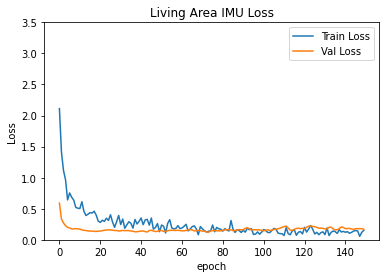

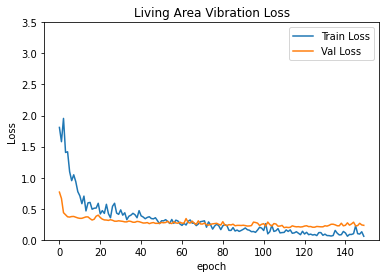

In [20]:
plt.plot(train_loss_i)
plt.plot(val_loss_i)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Living Area IMU Loss")
plt.legend(['Train Loss', 'Val Loss'])
plt.ylim([0, 3.5])
plt.show()

plt.plot(train_loss_v)
plt.plot(val_loss_v)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Living Area Vibration Loss")
plt.legend(['Train Loss', 'Val Loss'])
plt.ylim([0, 3.5])
plt.show()


In [21]:
inter_imu_conf_k = np.zeros((y_inter_i_k.shape[0],7))
inter_vib_conf_k = np.zeros((y_inter_v_k.shape[0],5))
tar_imu_conf_k = np.zeros((y_tar_i_k.shape[0],7))
tar_vib_conf_k = np.zeros((y_tar_v_k.shape[0],5))
inter_i_k_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_inter_i_k, y_inter_i_k_keras))
inter_i_k_dataset_for_eval = inter_i_k_dataset_for_eval.batch(1)
inter_v_k_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_inter_v_k, y_inter_v_k_keras))
inter_v_k_dataset_for_eval = inter_v_k_dataset_for_eval.batch(1)
tar_i_k_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_tar_i_k, y_tar_i_k_keras))
tar_i_k_dataset_for_eval = tar_i_k_dataset_for_eval.batch(1)
tar_v_k_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_tar_v_k, y_tar_v_k_keras))
tar_v_k_dataset_for_eval = tar_v_k_dataset_for_eval.batch(1)

In [22]:
inter_acc_v_k, inter_vib_conf_k = model_evaluate(model_vk, acc_metric, inter_v_k_dataset_for_eval, inter_vib_conf_k)
inter_acc_i_k, inter_imu_conf_k = model_evaluate(model_ik, acc_metric, inter_i_k_dataset_for_eval, inter_imu_conf_k)
tar_acc_v_k, tar_vib_conf_k = model_evaluate(model_vk, acc_metric, tar_v_k_dataset_for_eval, tar_vib_conf_k)
tar_acc_i_k, tar_imu_conf_k = model_evaluate(model_ik, acc_metric, tar_i_k_dataset_for_eval, tar_imu_conf_k)
print("Vibration Accuracy: Intermediate Living %.4f, Target Living %.4f" % (float(inter_acc_v_k),float(tar_acc_v_k)))
print("IMU Accuracy: Intermediate Living %.4f, Target Living %.4f" % (float(inter_acc_i_k),float(tar_acc_i_k)))

Vibration Accuracy: Intermediate Living 0.8854, Target Living 0.7063
IMU Accuracy: Intermediate Living 0.7103, Target Living 0.6536


In [23]:
# Save the intermediate result.
if save_inter:
    mat_dic = {"inter_imu_conf_w": inter_imu_conf_w, 
            "inter_vib_conf_w": inter_vib_conf_w,
            "tar_imu_conf_w": tar_imu_conf_w,
            "tar_vib_conf_w": tar_vib_conf_w,
            "inter_imu_conf_k": inter_imu_conf_k,
            "inter_vib_conf_k": inter_vib_conf_k,
            "tar_imu_conf_k": tar_imu_conf_k,
            "tar_vib_conf_k": tar_vib_conf_k,
            }

    savemat("../output/inter_and_baseline.mat", mat_dic)

### Prediction Fusion
Now, you need to go to MATLAB.

In the matlab, run post_process.m to fuse the multimodal prediction result, and get the fused result back for futher prediction. Remember to load `inter_and_baseline.mat` and comment out the `load final_result.mat` before running.

In this current example run

- AARA for predicing intermediate doamin: 0.86398
- AARA for M-A Direct Predict target domain: 0.70707

### Confidence-based Pseudo-labeled Data Selection.

In [24]:
fuse_result_mat = loadmat('../output/fused_result.mat')
conf_i_k = fuse_result_mat['conf_i_k']
conf_i_w = fuse_result_mat['conf_i_w']
conf_v_k = fuse_result_mat['conf_v_k']
conf_v_w = fuse_result_mat['conf_v_w']
pseu_i_k = fuse_result_mat['pseu_i_k'] 
pseu_i_w = fuse_result_mat['pseu_i_w']
pseu_v_k = fuse_result_mat['pseu_v_k'] 
pseu_v_w = fuse_result_mat['pseu_v_w']

In [25]:
#select by threshold
# ik
selected_ik4 = select_by_conf(conf_i_k, pseu_i_k, 4, eta)
selected_ik5 = select_by_conf(conf_i_k, pseu_i_k, 5, eta)
selected_ik6 = select_by_conf(conf_i_k, pseu_i_k, 6, eta)
selected_ik7 = select_by_conf(conf_i_k, pseu_i_k, 7, eta)
selected_ik8 = select_by_conf(conf_i_k, pseu_i_k, 8, eta)
selected_ik9 = select_by_conf(conf_i_k, pseu_i_k, 9, eta)
selected_ik10 = select_by_conf(conf_i_k, pseu_i_k, 10, eta)
row_ik = np.concatenate([selected_ik4, selected_ik5, selected_ik6, selected_ik7, selected_ik8, selected_ik9, selected_ik10])

# iw
selected_iw1 = select_by_conf(conf_i_w, pseu_i_w, 1, eta)
selected_iw2 = select_by_conf(conf_i_w, pseu_i_w, 2, eta)
selected_iw3 = select_by_conf(conf_i_w, pseu_i_w, 3, eta)
selected_iw10 = select_by_conf(conf_i_w, pseu_i_w, 10, eta)
row_iw = np.concatenate([selected_iw1, selected_iw2, selected_iw3, selected_iw10])

# vk
selected_vk4 = select_by_conf(conf_v_k, pseu_v_k, 4, eta)
selected_vk5 = select_by_conf(conf_v_k, pseu_v_k, 5, eta)
selected_vk6 = select_by_conf(conf_v_k, pseu_v_k, 6, eta)
selected_vk8 = select_by_conf(conf_v_k, pseu_v_k, 8, eta)
selected_vk9 = select_by_conf(conf_v_k, pseu_v_k, 9, eta)
row_vk = np.concatenate([selected_vk4, selected_vk5, selected_vk6, selected_vk8, selected_vk9])

# vw
selected_vw1 = select_by_conf(conf_v_w, pseu_v_w, 1, eta)
selected_vw2 = select_by_conf(conf_v_w, pseu_v_w, 2, eta)
selected_vw3 = select_by_conf(conf_v_w, pseu_v_w, 3, eta)
row_vw = np.concatenate([selected_vw1, selected_vw2, selected_vw3])

In [26]:
# conduct the selection 
X_sel_i_k = X_inter_i_k[row_ik]
pseu_i_k = pseu_i_k[row_ik]
X_sel_i_w = X_inter_i_w[row_iw]
pseu_i_w = pseu_i_w[row_iw]
X_sel_v_k = X_inter_v_k[row_vk]
pseu_v_k = pseu_v_k[row_vk]
X_sel_v_w = X_inter_v_w[row_vw]
pseu_v_w = pseu_v_w[row_vw]
print('Dataset volume change: ')
print('IMU Living:', X_inter_i_k.shape[0], '-->', X_sel_i_k.shape[0])
print('Vib Living:', X_inter_v_k.shape[0], '-->', X_sel_v_k.shape[0])
print('IMU Stding:', X_inter_i_w.shape[0], '-->', X_sel_i_w.shape[0])
print('Vib Stding:', X_inter_v_w.shape[0], '-->', X_sel_v_w.shape[0])

Dataset volume change: 
IMU Living: 1595 --> 686
Vib Living: 637 --> 321
IMU Stding: 638 --> 232
Vib Stding: 416 --> 237


In [27]:
encoder = OneHotEncoder()
# study
y_sel_i_w_keras = encoder.fit_transform(pseu_i_w.reshape(-1, 1))
y_sel_i_w_keras = y_sel_i_w_keras.todense()
y_sel_v_w_keras = encoder.fit_transform(pseu_v_w.reshape(-1, 1))
y_sel_v_w_keras = y_sel_v_w_keras.todense()

# living
y_sel_i_k_keras = encoder.fit_transform(pseu_i_k.reshape(-1, 1))
y_sel_i_k_keras = y_sel_i_k_keras.todense()
y_sel_v_k_keras = encoder.fit_transform(pseu_v_k.reshape(-1, 1))
y_sel_v_k_keras = y_sel_v_k_keras.todense()

In [28]:
# format the data into a tf dataset for alternative training
# studying area
sel_i_w_dataset = tf.data.Dataset.from_tensor_slices((X_sel_i_w, y_sel_i_w_keras))
sel_i_w_dataset = sel_i_w_dataset.shuffle(buffer_size=1024).batch(batch_size)
sel_v_w_dataset = tf.data.Dataset.from_tensor_slices((X_sel_v_w, y_sel_v_w_keras))
sel_v_w_dataset = sel_v_w_dataset.shuffle(buffer_size=1024).batch(batch_size)
tar_i_w_dataset = tf.data.Dataset.from_tensor_slices((X_tar_i_w, y_tar_i_w_keras))
tar_i_w_dataset = tar_i_w_dataset.shuffle(buffer_size=1024).batch(batch_size)
tar_v_w_dataset = tf.data.Dataset.from_tensor_slices((X_tar_v_w, y_tar_v_w_keras))
tar_v_w_dataset = tar_v_w_dataset.shuffle(buffer_size=1024).batch(batch_size)

# living area
sel_i_k_dataset = tf.data.Dataset.from_tensor_slices((X_sel_i_k, y_sel_i_k_keras))
sel_i_k_dataset = sel_i_k_dataset.shuffle(buffer_size=1024).batch(batch_size)
sel_v_k_dataset = tf.data.Dataset.from_tensor_slices((X_sel_v_k, y_sel_v_k_keras))
sel_v_k_dataset = sel_v_k_dataset.shuffle(buffer_size=1024).batch(batch_size)
tar_i_k_dataset = tf.data.Dataset.from_tensor_slices((X_tar_i_k, y_tar_i_k_keras))
tar_i_k_dataset = tar_i_k_dataset.shuffle(buffer_size=1024).batch(batch_size)
tar_v_k_dataset = tf.data.Dataset.from_tensor_slices((X_tar_v_k, y_tar_v_k_keras))
tar_v_k_dataset = tar_v_k_dataset.shuffle(buffer_size=1024).batch(batch_size)

Studying Area Network

In [29]:
# modality-specific input layer
input_i = layers.Input(shape=(216,))
input_v = layers.Input(shape=(980,))
x_i_1 = layers.Dense(128, activation="elu", name = 'X_i_1')(input_i)
x_i_d = layers.Dropout(0.5, name = 'i_dropout')(x_i_1)
x_v_1 = layers.Dense(128, activation="elu", name = 'X_v_1')(input_v)
x_v_d = layers.Dropout(0.5, name = 'v_dropout')(x_v_1)

# combined together
x_imu = shared_layers_w(x_i_d)
x_vib = shared_layers_w(x_v_d )
output_i = layers.Dense(4)(x_imu)
output_v = layers.Dense(3)(x_vib)
model_iw = keras.Model(inputs=input_i, outputs=output_i, name="imu_model")
model_vw = keras.Model(inputs=input_v, outputs=output_v, name="vib_model")

# saving results for further plotting
train_loss_i = list()
tar_loss_i = list()
train_loss_v = list()
tar_loss_v = list()

In [30]:
flag = 1
for epoch in range(num_epoch):
    if verbose:
        print("\nStart of epoch %d" % (epoch,))
    if flag >= 0:
        # Iterate over the batches of the dataset.
        for step, (x_batch_sel_i, y_batch_sel_i) in enumerate(sel_i_w_dataset):
            with tf.GradientTape() as tape:
                logits_i = model_iw(x_batch_sel_i, training=True)  # Logits for this minibatch
                loss_value_i = loss_i(y_batch_sel_i, logits_i)
            grads_i = tape.gradient(loss_value_i, model_iw.trainable_weights)
            opt_i.apply_gradients(zip(grads_i, model_iw.trainable_weights))
        if verbose:
            print("Training loss of model_iw at epoch %d: %.4f" % (epoch + 1, float(loss_value_i)))
        for x_batch_tar_i, y_batch_tar_i in tar_i_w_dataset:
            tar_logits_i = model_iw(x_batch_tar_i, training=False)
            tar_loss_value_i = loss_i(y_batch_tar_i, tar_logits_i)
        if verbose:
            print("Val loss of model_iw at epoch %d: %.4f"% (epoch + 1, float(tar_loss_value_i)))
        train_loss_i.append(float(loss_value_i))
        tar_loss_i.append(float(tar_loss_value_i))
        flag *= -1
    else:
        for step, (x_batch_sel_v, y_batch_sel_v) in enumerate(sel_v_w_dataset):
            with tf.GradientTape() as tape:
                logits_v = model_vw(x_batch_sel_v, training=True)  # Logits for this minibatch
                loss_value_v = loss_v(y_batch_sel_v, logits_v)
            grads_v = tape.gradient(loss_value_v, model_vw.trainable_weights)
            opt_v.apply_gradients(zip(grads_v, model_vw.trainable_weights))
        if verbose:
            print("Training loss of model_vw at epoch %d: %.4f"% (epoch + 1, float(loss_value_v)))
        for x_batch_tar_v, y_batch_tar_v in tar_v_w_dataset:
            tar_logits_v = model_vw(x_batch_tar_v, training=False)
            tar_loss_value_v = loss_v(y_batch_tar_v, tar_logits_v)
        if verbose:
            print("Val loss of model_vw at epoch %d: %.4f" % (epoch + 1, float(tar_loss_value_v)))
        train_loss_v.append(float(loss_value_v))
        tar_loss_v.append(float(tar_loss_value_v))
        flag *= -1

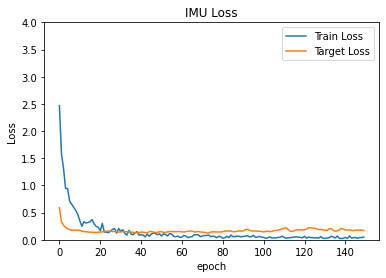

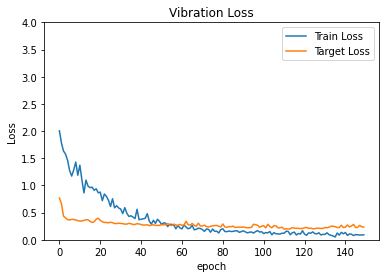

In [31]:
plt.plot(train_loss_i)
plt.plot(val_loss_i)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("IMU Loss")
plt.legend(['Train Loss', 'Target Loss'])
plt.ylim([0, 4])
plt.show()

plt.plot(train_loss_v)
plt.plot(val_loss_v)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Vibration Loss")
plt.legend(['Train Loss', 'Target Loss'])
plt.ylim([0, 4])
plt.show()

In [32]:
sel_imu_conf_w = np.zeros((pseu_i_w.shape[0],4))
sel_vib_conf_w = np.zeros((pseu_v_w.shape[0],3))
tar_imu_conf_w = np.zeros((y_tar_i_w.shape[0],4))
tar_vib_conf_w = np.zeros((y_tar_v_w.shape[0],3))

tar_i_w_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_tar_i_w, y_tar_i_w_keras))
tar_i_w_dataset_for_eval = tar_i_w_dataset_for_eval.batch(1)
tar_v_w_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_tar_v_w, y_tar_v_w_keras))
tar_v_w_dataset_for_eval = tar_v_w_dataset_for_eval.batch(1)

In [33]:
tar_acc_v_w, tar_vib_conf_w = model_evaluate(model_vw, acc_metric, tar_v_w_dataset_for_eval , tar_vib_conf_w)
tar_acc_i_w, tar_imu_conf_w = model_evaluate(model_iw, acc_metric, tar_i_w_dataset_for_eval , tar_imu_conf_w)
print("Vibration Accuracy, Target Studing %.4f" % (float(tar_acc_v_w)))
print("IMU Accuracy, Target Studing %.4f" % (float(tar_acc_i_w)))

Vibration Accuracy, Target Studing 0.3498
IMU Accuracy, Target Studing 0.7569


Living Area Network

In [34]:
# modality-specific input layer
input_i = layers.Input(shape=(216,))
input_v = layers.Input(shape=(980,))
x_i_1 = layers.Dense(128, activation="elu", name = 'X_i_1')(input_i)
x_i_d = layers.Dropout(0.5, name = 'i_dropout')(x_i_1)
x_v_1 = layers.Dense(128, activation="elu", name = 'X_v_1')(input_v)
x_v_d = layers.Dropout(0.5, name = 'v_dropout')(x_v_1)

# combined together
x_imu = shared_layers_k(x_i_d)
x_vib = shared_layers_k(x_v_d )
output_i = layers.Dense(7)(x_imu)
output_v = layers.Dense(5)(x_vib)
model_ik = keras.Model(inputs=input_i, outputs=output_i, name="imu_model")
model_vk = keras.Model(inputs=input_v, outputs=output_v, name="vib_model")

# saving results for further plotting
train_loss_i = list()
tar_loss_i = list()
train_loss_v = list()
tar_loss_v = list()

In [35]:
flag = 1
for epoch in range(num_epoch):
    if verbose:
        print("\nStart of epoch %d" % (epoch,))
    if flag >= 0:
        # Iterate over the batches of the dataset.
        for step, (x_batch_sel_i, y_batch_sel_i) in enumerate(sel_i_k_dataset):
            with tf.GradientTape() as tape:
                logits_i = model_ik(x_batch_sel_i, training=True)
                loss_value_i = loss_i(y_batch_sel_i, logits_i)
            grads_i = tape.gradient(loss_value_i, model_ik.trainable_weights)
            opt_i.apply_gradients(zip(grads_i, model_ik.trainable_weights))
        if verbose:
            print("Training loss of model_ik at epoch %d: %.4f" % (epoch + 1, float(loss_value_i)))
        for x_batch_tar_i, y_batch_tar_i in tar_i_k_dataset:
            tar_logits_i = model_ik(x_batch_tar_i, training=False)
            tar_loss_value_i = loss_i(y_batch_tar_i, tar_logits_i)
        if verbose:
            print("Val loss of model_ik at epoch %d: %.4f"% (epoch + 1, float(tar_loss_value_i)))
        train_loss_i.append(float(loss_value_i))
        tar_loss_i.append(float(tar_loss_value_i))
        flag *= -1
    else:
        for step, (x_batch_sel_v, y_batch_sel_v) in enumerate(sel_v_k_dataset):
            with tf.GradientTape() as tape:
                logits_v = model_vk(x_batch_sel_v, training=True)
                loss_value_v = loss_v(y_batch_sel_v, logits_v)
            grads_v = tape.gradient(loss_value_v, model_vk.trainable_weights)
            opt_v.apply_gradients(zip(grads_v, model_vk.trainable_weights))
        if verbose:
            print("Training loss of model_vk at epoch %d: %.4f"% (epoch + 1, float(loss_value_v)))
        for x_batch_tar_v, y_batch_tar_v in tar_v_k_dataset:
            tar_logits_v = model_vk(x_batch_tar_v, training=False)
            tar_loss_value_v = loss_v(y_batch_tar_v, tar_logits_v)
        if verbose:
            print("Val loss of model_vk at epoch %d: %.4f" % (epoch + 1, float(tar_loss_value_v)))
        train_loss_v.append(float(loss_value_v))
        tar_loss_v.append(float(tar_loss_value_v))
        flag *= -1


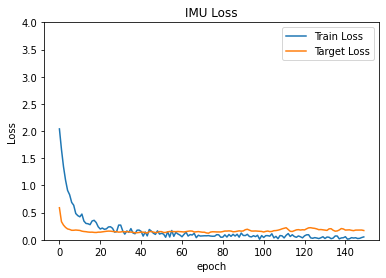

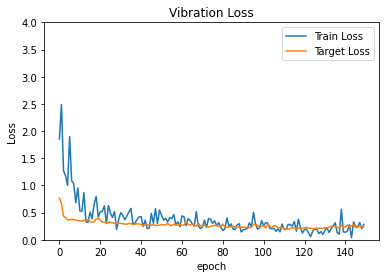

In [36]:
plt.plot(train_loss_i)
plt.plot(val_loss_i)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("IMU Loss")
plt.legend(['Train Loss', 'Target Loss'])
plt.ylim([0, 4])
plt.show()

plt.plot(train_loss_v)
plt.plot(val_loss_v)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Vibration Loss")
plt.legend(['Train Loss', 'Target Loss'])
plt.ylim([0, 4])
plt.show()

In [37]:
tar_imu_conf_k = np.zeros((y_tar_i_k.shape[0],7))
tar_vib_conf_k = np.zeros((y_tar_v_k.shape[0],5))

tar_i_k_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_tar_i_k, y_tar_i_k_keras))
tar_i_k_dataset_for_eval = tar_i_k_dataset_for_eval.batch(1)
tar_v_k_dataset_for_eval = tf.data.Dataset.from_tensor_slices((X_tar_v_k, y_tar_v_k_keras))
tar_v_k_dataset_for_eval = tar_v_k_dataset_for_eval.batch(1)

In [38]:
tar_acc_v_k, tar_vib_conf_k = model_evaluate(model_vk, acc_metric, tar_v_k_dataset_for_eval , tar_vib_conf_k)
tar_acc_i_k, tar_imu_conf_k = model_evaluate(model_ik, acc_metric, tar_i_k_dataset_for_eval , tar_imu_conf_k)
print("Vibration Accuracy, Target Living %.4f" % (float(tar_acc_v_k)))
print("IMU Accuracy, Target Living %.4f" % (float(tar_acc_i_k)))

Vibration Accuracy, Target Living 0.6388
IMU Accuracy, Target Living 0.6492


In [39]:
if save_final:
    mat_dic = {
        "tar_imu_conf_w": tar_imu_conf_w,
        "tar_vib_conf_w": tar_vib_conf_w,
        "tar_imu_conf_k": tar_imu_conf_k,
        "tar_vib_conf_k": tar_vib_conf_k,
        }
    savemat("../output/final_result.mat", mat_dic)

### Now you should go to MATLAB for the final result.

Run `post_process.m` again. Remember to `load final_result.m` in this time.

The AARA of VMA predicting target domain is 0.75112.